In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statistics
import tqdm

input_file = open('prices.txt', 'r')
number_of_stocks = 50
price_list = []

for i in range(number_of_stocks):
    price_list.append([])

for line in input_file:
    tokens = line.split('\n')[0].split('   ')
    #print(tokens)
    #break
    for i in range(number_of_stocks):
        price_list[i].append(float(tokens[i]))
df = pd.DataFrame()

for i in range(number_of_stocks):
    df[f'stock_{i}'] = price_list[i]

train_n = 250

df_train = df.iloc[0:train_n]
df_test = df.iloc[train_n:]

## Price Movement Lag

stock_22 leads stock_27 by 1 days corr = 0.3404700573069867
stock_22 leads stock_27 by 1 days OUT OF SAMPLE corr = 0.2631522335884033
stock_22 leads stock_38 by 1 days corr = 0.41382484815008846
stock_22 leads stock_38 by 1 days OUT OF SAMPLE corr = 0.33129717598859887
stock_25 leads stock_27 by 1 days corr = 0.3172439930439101
stock_25 leads stock_27 by 1 days OUT OF SAMPLE corr = 0.23389571786142002
stock_25 leads stock_38 by 1 days corr = 0.34296571547458143
stock_25 leads stock_38 by 1 days OUT OF SAMPLE corr = 0.15080033764775594
stock_30 leads stock_38 by 1 days corr = 0.352601840413688
stock_30 leads stock_38 by 1 days OUT OF SAMPLE corr = 0.3173152595603051
stock_38 leads stock_27 by 1 days corr = 0.3221033645791748
stock_38 leads stock_27 by 1 days OUT OF SAMPLE corr = 0.2501016707862918


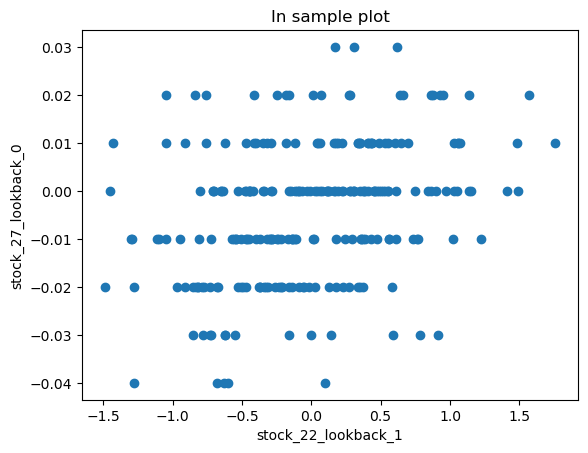

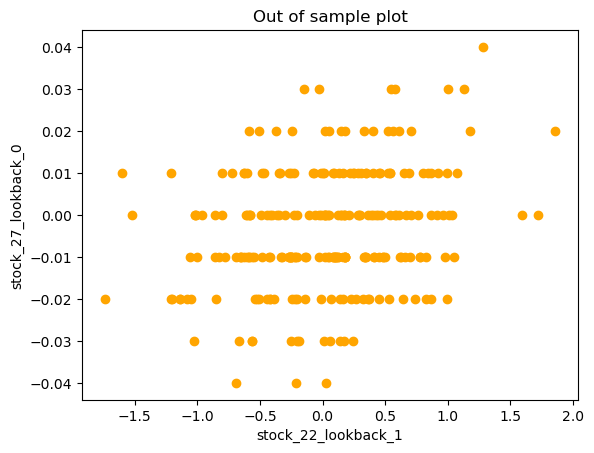

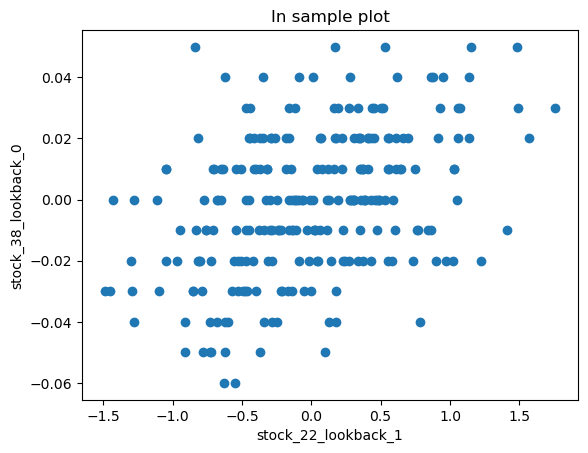

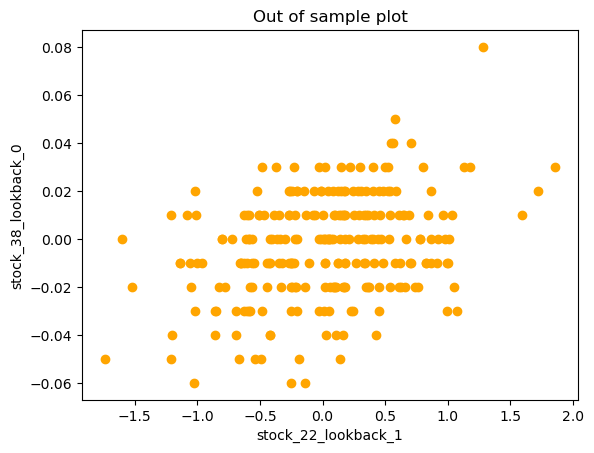

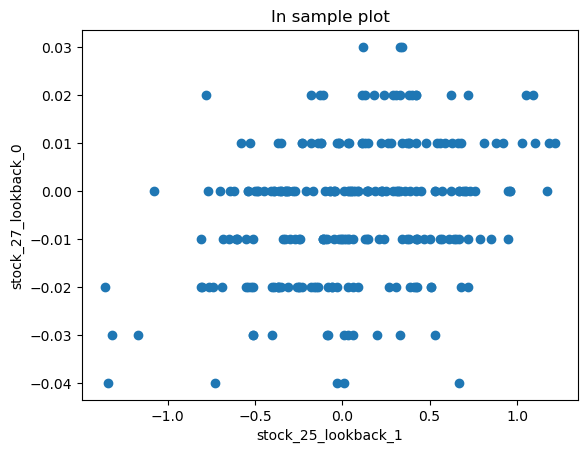

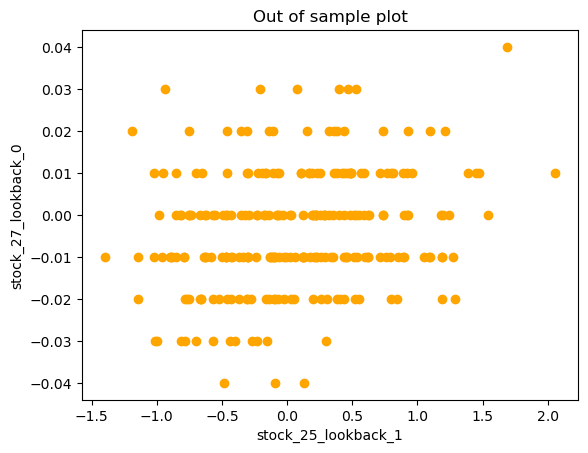

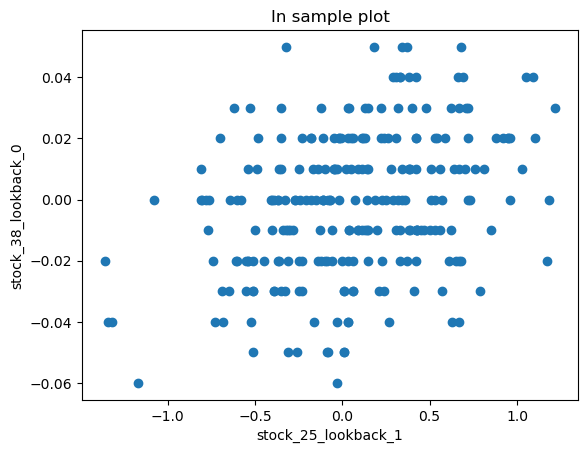

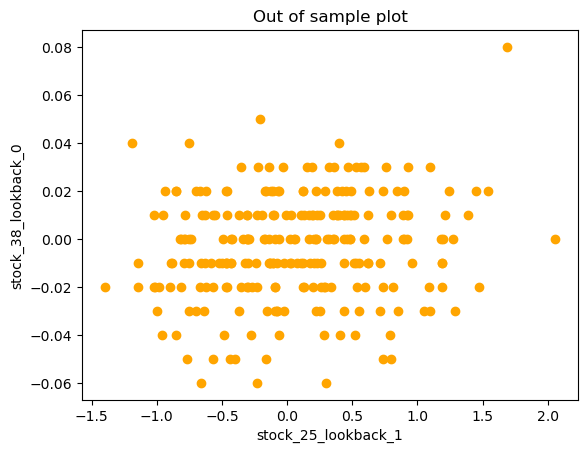

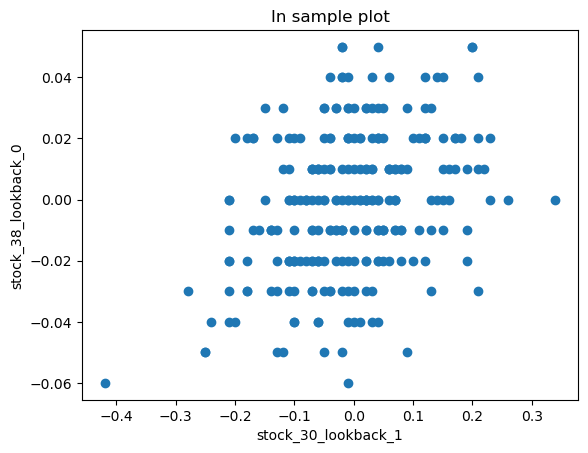

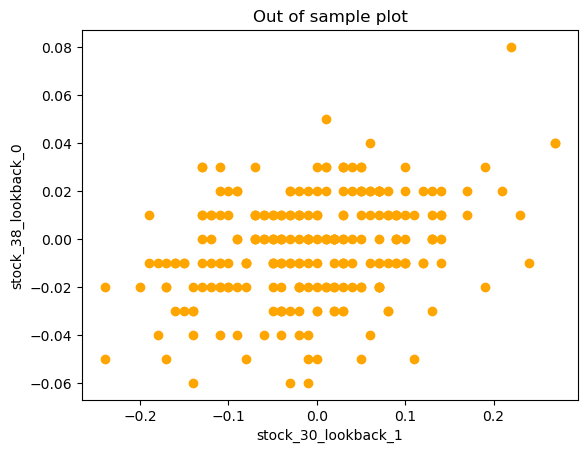

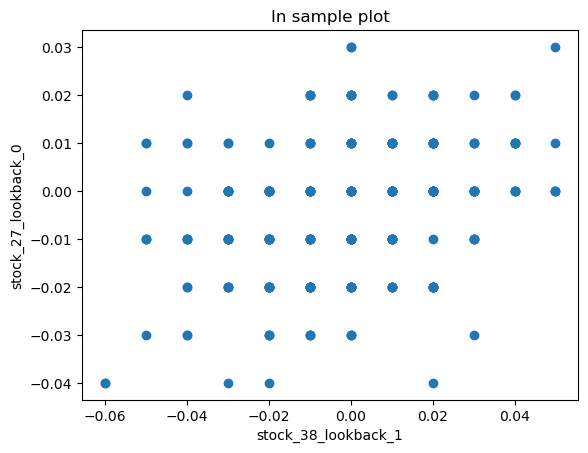

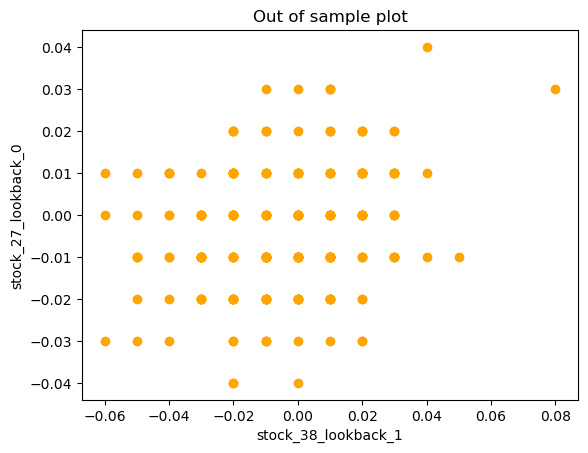

<Figure size 640x480 with 0 Axes>

In [39]:
pd.options.mode.chained_assignment = None

window = 1
lag = 1
corr_limit = 0.3

for i in range(number_of_stocks):
    for j in range(number_of_stocks):
        if i != j:
            df_corr = pd.DataFrame()
            df_corr[f'stock_{i}_lookback_1'] = df_train[f'stock_{i}'].diff(window).shift(lag)
            df_corr[f'stock_{j}_lookback_0'] = df_train[f'stock_{j}'].diff(window)

            df_corr.dropna(inplace = True)
            corrcoef = np.corrcoef(df_corr[f'stock_{i}_lookback_1'],  df_corr[f'stock_{j}_lookback_0'])[0, 1]
            if abs(corrcoef) > corr_limit:
                print(f'stock_{i} leads stock_{j} by {lag} days corr = {corrcoef}')
                plt.scatter(df_corr[f'stock_{i}_lookback_1'], df_corr[f'stock_{j}_lookback_0'])
                plt.title('In sample plot')
                plt.xlabel(f'stock_{i}_lookback_1')
                plt.ylabel(f'stock_{j}_lookback_0')
                plt.figure()

                df_check = pd.DataFrame()
                df_check[f'stock_{i}_lookback_1'] = df_test[f'stock_{i}'].diff(window).shift(lag)
                df_check[f'stock_{j}_lookback_0'] = df_test[f'stock_{j}'].diff(window)
                df_check.dropna(inplace = True)

                oos_corr = np.corrcoef(df_check[f'stock_{i}_lookback_1'],  df_check[f'stock_{j}_lookback_0'])[0, 1]

                print(f'stock_{i} leads stock_{j} by {lag} days OUT OF SAMPLE corr = {oos_corr}')
                plt.scatter(df_check[f'stock_{i}_lookback_1'], df_check[f'stock_{j}_lookback_0'], color = 'orange')
                plt.title('Out of sample plot')
                plt.xlabel(f'stock_{i}_lookback_1')
                plt.ylabel(f'stock_{j}_lookback_0')
                plt.figure()
                

## Prices Lag

In [ ]:
pd.options.mode.chained_assignment = None

window = 10
lag = 30
corr_limit = 0.9

for i in range(number_of_stocks):
    for j in range(number_of_stocks):
        if i != j:
            df_corr = pd.DataFrame()
            df_corr[f'stock_{i}_lookback_1'] = df_train[f'stock_{i}'].shift(lag)
            df_corr[f'stock_{j}_lookback_0'] = df_train[f'stock_{j}']

            df_corr.dropna(inplace = True)
            corrcoef = np.corrcoef(df_corr[f'stock_{i}_lookback_1'],  df_corr[f'stock_{j}_lookback_0'])[0, 1]
            if abs(corrcoef) > corr_limit:
                print(f'stock_{i} leads stock_{j} by {lag} days corr = {corrcoef}')
                plt.scatter(df_corr[f'stock_{i}_lookback_1'], df_corr[f'stock_{j}_lookback_0'])
                plt.title('In sample plot')
                plt.xlabel(f'stock_{i}_lookback_1')
                plt.ylabel(f'stock_{j}_lookback_0')
                plt.figure()

                df_check = pd.DataFrame()
                df_check[f'stock_{i}_lookback_1'] = df_test[f'stock_{i}'].shift(lag)
                df_check[f'stock_{j}_lookback_0'] = df_test[f'stock_{j}']
                df_check.dropna(inplace = True)
                
                plt.scatter(df_check[f'stock_{i}_lookback_1'], df_check[f'stock_{j}_lookback_0'], color = 'orange')
                plt.title('Out of sample plot')
                plt.xlabel(f'stock_{i}_lookback_1')
                plt.ylabel(f'stock_{j}_lookback_0')
                plt.figure()

In [ ]:
iv = 'stock_38'
dv = 'stock_39'

y = df[dv]
X = sm.add_constant(df[iv])
testmodel = sm.OLS( y,  X)
results = testmodel.fit()
print(results.summary())

plt.plot(df[dv])
plt.plot(results.predict(sm.add_constant(df[iv])))

In [ ]:
results.pvalues['stock_38']

In [ ]:
plt.scatter(df['stock_39'].diff().shift(1), df['stock_38'].diff())

In [ ]:
plt.scatter(df['stock_38'].diff().shift(1), df['stock_39'].diff())

In [37]:
signals = []

max_lags = 2
target_forecast = 20
"""
Forecasting 1 day signal
"""
windows = [5, 10, 20]
rsquared_limit = 0.1
alpha = 0.01

for i in range(number_of_stocks):
    print('.', end = '')
    current_stock_signals = []
    ## FIND SIGNALS IN DATA:
    for j in range(number_of_stocks):
        for window in windows:
            for offset in range(0, max_lags):
                df_temp = pd.DataFrame()
                df_temp['target'] = df[f'stock_{i}'].diff(target_forecast)
                df_temp[f'stock_{j}_window_{window}_offset_{offset}'] = df[f'stock_{j}'].diff(window).shift(target_forecast + window * offset)
                df_temp.dropna(inplace = True)

                X = sm.add_constant(df_temp[f'stock_{j}_window_{window}_offset_{offset}'])
                y = df_temp['target']
                
                model = sm.OLS(y, X)
                results = model.fit(vcov = 'HC3')

                if results.pvalues[f'stock_{j}_window_{window}_offset_{offset}'] < alpha:## and results.rsquared > rsquared_limit:
                    current_stock_signals.append((f'stock_{j}_window_{window}_offset_{offset}',\
                                                      results.params[f'stock_{j}_window_{window}_offset_{offset}'],
                                                     results.params['const']))
                        
    signals.append(current_stock_signals)

..................................................

In [38]:
signals

[[('stock_0_window_5_offset_1', 0.26323886921267725, -0.006615927298684893),
  ('stock_0_window_10_offset_0', 0.19352317118499135, -0.005996638037147885),
  ('stock_0_window_10_offset_1', 0.43769106492157567, 0.0003254966741411325),
  ('stock_0_window_20_offset_0', 0.31022770020579327, 0.0010470389929507116),
  ('stock_1_window_10_offset_1', 0.05395836964239834, 0.003426162691263011),
  ('stock_1_window_20_offset_0', 0.04581910396400336, 0.006889353300590801),
  ('stock_1_window_20_offset_1', 0.09340911331795873, 0.0426749435107759),
  ('stock_2_window_5_offset_0', -0.709200332157127, -0.02314942999683515),
  ('stock_2_window_10_offset_0', -0.46805929597271, -0.02585180923802248),
  ('stock_2_window_20_offset_0', -0.34211800209633747, -0.030923866919825595),
  ('stock_2_window_20_offset_1', -0.3599626584140072, -0.010660479302275132),
  ('stock_3_window_5_offset_1', 0.26731026184621787, 0.008010900841293177),
  ('stock_3_window_10_offset_1', 0.26468162134444473, 0.028416701120325644),


In [34]:
iv = 38
dv = 27
window = 1

df_modelling = df_train[[f'stock_{iv}', f'stock_{dv}']]
df_modelling[f'stock_{iv}_lookback_1'] = df_modelling[f'stock_{iv}'].diff(window).shift(window)
df_modelling[f'stock_{dv}_lookback_1'] = df_modelling[f'stock_{dv}'].diff(window).shift(window)
df_modelling[f'stock_{dv}_lookback_0'] = df_modelling[f'stock_{dv}'].diff(window)

df_modelling.dropna(inplace = True)
y = df_modelling[f'stock_{dv}_lookback_0']
X = sm.add_constant(df_modelling[[f'stock_{dv}_lookback_1']])#f'stock_{iv}_lookback_1'
model = sm.OLS(y, X)
results = model.fit(vcov = 'HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     stock_27_lookback_0   R-squared:                       0.085
Model:                             OLS   Adj. R-squared:                  0.081
Method:                  Least Squares   F-statistic:                     22.71
Date:                 Tue, 25 Jun 2024   Prob (F-statistic):           3.23e-06
Time:                         12:13:19   Log-Likelihood:                 710.60
No. Observations:                  248   AIC:                            -1417.
Df Residuals:                      246   BIC:                            -1410.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0031      0.001     -3.397      0.001      -0.005      -0.001
stock_27_lookback_1     0.2854      0.060      4.765      0.000       0.167       0.403
==============================================================================
Omnibus:                        1.507   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.577
Skew:                          -0.147   Prob(JB):                        0.454
Kurtosis:                       2.744   Cond. No.                         68.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

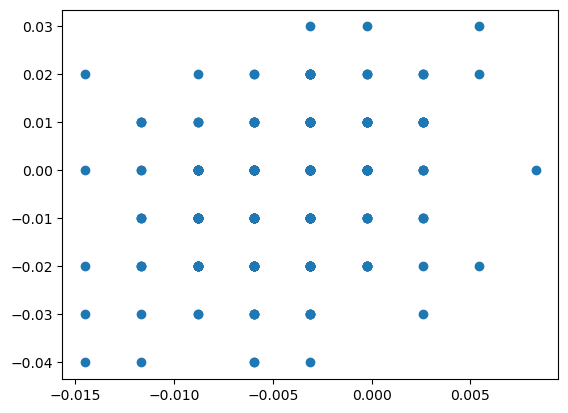

In [36]:
plt.scatter(results.predict(X), y)

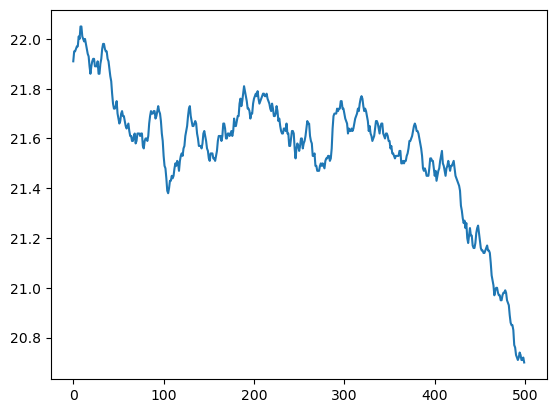

In [24]:
plt.plot(df[f'stock_38'])